# Challenge - Time Series Analysis
Using a different time series data set (either from FRED or elsewhere, go about the process of time series modeling. Specifically generate the following things:

* Plot the time series, along with any logical or necessary differences to get a stationary dataset
* Generate and interpret a PACF for the time series (and/or its differences)
* Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data
* Finally choose one specification and make the case for that as a logical model for your dataset.

The data here comes from the St. Louis Federal Reserve's database, affectionately called FRED and available [here](https://fred.stlouisfed.org). I used ten years of the Unemployment Rate data, starting Feb 1, 2010. I also referred to http://people.duke.edu/~rnau/411arim3.htm for help interpreting the results.

## Load Data

In [1]:
import numpy as np
import pandas as pd
import scipy
import datetime as datetime
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import pmdarima as pm

%matplotlib inline

In [2]:
# Load data
unemployment = pd.read_csv('UNRATE.csv')

# Convert rate to a number, with coersion to throw NA if conversion not possible
unemployment['unemp_rate'] = pd.to_numeric(unemployment.UNRATE, errors='coerce')

# Drop NA
unemployment.dropna(inplace=True)

In [3]:
# Preview data
unemployment.head()

,DATE,UNRATE,unemp_rate
0,2010-02-01,9.8,9.8
1,2010-03-01,9.9,9.9
2,2010-04-01,9.9,9.9
3,2010-05-01,9.6,9.6
4,2010-06-01,9.4,9.4


## Plot Time Series

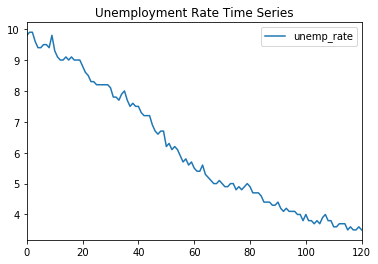

In [4]:
# Plot unemployment rate time series
unemployment.plot(y='unemp_rate')
plt.title('Unemployment Rate Time Series')
plt.show()

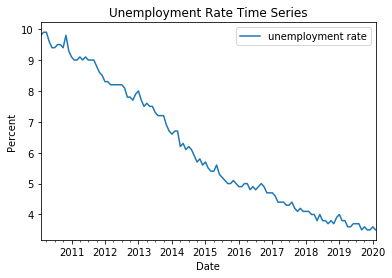

In [5]:
# Make datetime the index so x axis is meaningful
unemployment.index = pd.to_datetime(unemployment.DATE)

# Plot unemployment rate time series
unemployment.plot(y='unemp_rate')
plt.title('Unemployment Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend(['unemployment rate'])

plt.show()

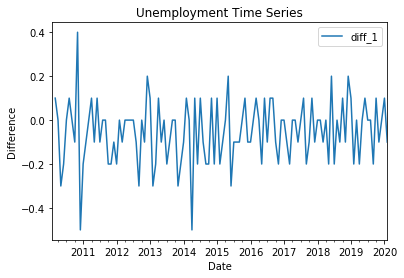

In [6]:
# Take first difference
unemployment['diff_1'] = unemployment.unemp_rate - unemployment.unemp_rate.shift()

# Plot first difference to see if data set is stationary
unemployment.plot(y='diff_1')
plt.title('Unemployment Time Series')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.show()

The original data set had a constant downward trend, but the first difference appears to be stationary.

## Plot ACF and PACF

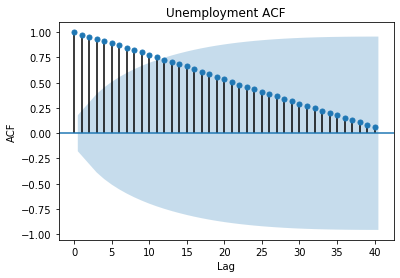

In [7]:
# Use ACF to find most optimal MA(q) model
plot_acf(unemployment.unemp_rate, lags=40, alpha=0.05)
plt.title('Unemployment ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

The autocorrelations are significant for a large number of lags.

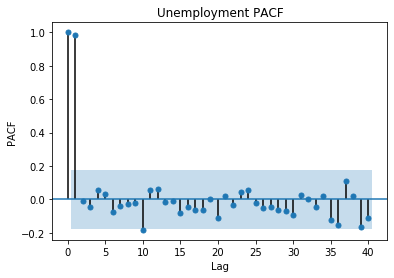

In [9]:
# Use PACF to find most optimal AR(p) model
plot_pacf(unemployment.unemp_rate, lags=40, alpha=0.05)
plt.title('Unemployment PACF')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

However, the PACF plot confirms that the autocorrelations at two and above in the ACF are due to the propagation of the autocorrelation at lag 1. This result suggests that in the absence of differencing (I=0), an AR(1) model would be appropriate. Moreover, the height of the PACF spike at lag 1 is essentially 1, confirming that the unemployment time series data needs an order of differencing (I=1) to be stationary.

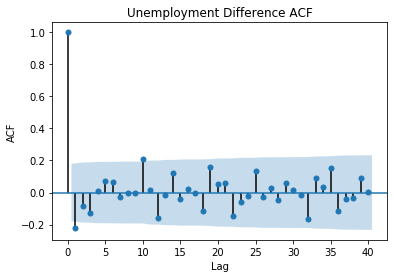

In [8]:
# Use ACF to find most optimal MA(q) model
plot_acf(unemployment.diff_1[1:], lags=40, alpha=0.05)
plt.title('Unemployment Difference ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

The autocorrelation at lag 1 is significant and negative, suggesting that the series is slightly "overdifferenced" and the model could use an MA term (q=1).

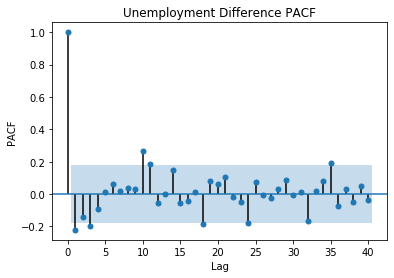

In [10]:
# Use PACF to find most optimal AR(p) model
plot_pacf(unemployment.diff_1[1:], lags=40, alpha=0.05)
plt.title('Unemployment Difference PACF')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

The autocorrelation at lags 1 is significant, but negative, suggesting that an AR term may not be beneficial to the model (p=0). Thus, based on these analyses, I will first try an ARIMA(0, 1, 1) model.

## Build Models

### ARIMA(0, 1, 1)

In [41]:
model = ARIMA(unemployment.unemp_rate, order=(0, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.unemp_rate   No. Observations:                  120
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  70.325
Method:                       css-mle   S.D. of innovations              0.135
Date:                Sun, 22 Mar 2020   AIC                           -134.651
Time:                        13:34:42   BIC                           -126.288
Sample:                    03-01-2010   HQIC                          -131.255
                         - 02-01-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0529      0.008     -6.414      0.000      -0.069      -0.037
ma.L1.D.unemp_rate    -0.3315      0.107     -3.110      0.002      -0.540      -0.123
                    

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


#### Conclusion
* Constant is -0.0529
* MA(1) coefficient is -0.3315 (p < 0.05)
* Log likelihood is 70.325
* AIC is -134.651 (81.9% chance this model minimizes information loss compared to ARIMA(0, 1, 2))

### ARIMA(1, 0, 0)

In [11]:
model = ARIMA(unemployment.unemp_rate, order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             unemp_rate   No. Observations:                  121
Model:                     ARMA(1, 0)   Log Likelihood                  55.540
Method:                       css-mle   S.D. of innovations              0.149
Date:                Sat, 21 Mar 2020   AIC                           -105.079
Time:                        22:05:31   BIC                            -96.692
Sample:                    02-01-2010   HQIC                          -101.673
                         - 02-01-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.6156      2.933      2.256      0.024       0.868      12.363
ar.L1.unemp_rate     0.9988      0.002    602.195      0.000       0.996       1.002
                            

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


#### Conclusion
* Constant is 6.6156
* AR(1) coefficient is 0.9988 (p < 0.05), suggesting that each day is approximately equal to the previous day's value
* Log likelihood is 55.54, which is the best of the models tested here (closest to 0), suggesting that this model has a higher probability of correctly predicting unemployment rates than the other models
* AIC is -105.079 (0.0% chance this model minimizes information loss compared to ARIMA(0, 1, 2))

### ARIMA(0, 1, 0)

In [12]:
model = ARIMA(unemployment.unemp_rate, order=(0, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.unemp_rate   No. Observations:                  120
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  65.987
Method:                           css   S.D. of innovations              0.140
Date:                Sat, 21 Mar 2020   AIC                           -127.974
Time:                        22:05:31   BIC                           -122.399
Sample:                    03-01-2010   HQIC                          -125.710
                         - 02-01-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0525      0.013     -4.119      0.000      -0.077      -0.028


#### Conclusion
* Constant is -0.0525
* Log likelihood is 65.987
* AIC is -127.974 (0.1% chance this model minimizes information loss compared to ARIMA(0, 1, 2))

### ARIMA(0, 0, 1)

In [13]:
model = ARIMA(unemployment.unemp_rate, order=(0, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:             unemp_rate   No. Observations:                  121
Model:                     ARMA(0, 1)   Log Likelihood                -181.920
Method:                       css-mle   S.D. of innovations              1.067
Date:                Sat, 21 Mar 2020   AIC                            369.841
Time:                        22:05:31   BIC                            378.228
Sample:                    02-01-2010   HQIC                           373.247
                         - 02-01-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.1492      0.193     31.833      0.000       5.771       6.528
ma.L1.unemp_rate     0.9999      0.032     31.040      0.000       0.937       1.063
                            

#### Conclusion
* Constant is 6.1492
* MA(1) coefficient is 0.9999 (p < 0.05)
* Log likelihood is -181.92, which is the worst of the models tested here (farthest from 0), suggesting that this model has a lower probability of correctly predicting unemployment rates than the other models
* AIC is 369.841, which is the worst of the models tested here (largest value) (0.0% chance this model minimizes information loss compared to ARIMA(0, 1, 2))

### ARIMA(1, 1, 0)

In [14]:
model = ARIMA(unemployment.unemp_rate, order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.unemp_rate   No. Observations:                  120
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  68.959
Method:                       css-mle   S.D. of innovations              0.136
Date:                Sat, 21 Mar 2020   AIC                           -131.918
Time:                        22:05:31   BIC                           -123.555
Sample:                    03-01-2010   HQIC                          -128.522
                         - 02-01-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0527      0.010     -5.160      0.000      -0.073      -0.033
ar.L1.D.unemp_rate    -0.2201      0.089     -2.470      0.014      -0.395      -0.045
                    

#### Conclusion
* Constant is -0.0527
* AR(1) coefficient is -0.2201 (p < 0.05)
* Log likelihood is 68.959
* AIC is -131.918 (20.9% chance this model minimizes information loss compared to ARIMA(0, 1, 2))

### ARIMA(1, 1, 1)

In [15]:
model = ARIMA(unemployment.unemp_rate, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.unemp_rate   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  71.514
Method:                       css-mle   S.D. of innovations              0.133
Date:                Sat, 21 Mar 2020   AIC                           -135.028
Time:                        22:05:31   BIC                           -123.878
Sample:                    03-01-2010   HQIC                          -130.500
                         - 02-01-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0530      0.007     -7.512      0.000      -0.067      -0.039
ar.L1.D.unemp_rate     0.3026      0.173      1.748      0.081      -0.037       0.642
ma.L1.D.unemp_rate  

#### Conclusion
* Constant is -0.0530
* AR(1) coefficient is 0.3026 (p > 0.81), which suggests that this term does not have a significant effect on our outcome and is likely unnecessary
* MA(1) coefficient is -0.5988 (p < 0.05)
* Log likelihood is 71.514
* AIC is -135.028 (98.9% chance this model minimizes information loss compared to ARIMA(0, 1, 2))

### Auto ARIMA Using pmdarima

In [39]:
stepwise_fit = pm.auto_arima(unemployment.unemp_rate,
                             start_p=1, max_p=3,
                             d=1,
                             start_q=1, max_q=3,
                             trace=True, # show individual results
                             seasonal=False, # don't want to correct for seasonality
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-135.028, BIC=-123.878, Time=0.122 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-127.974, BIC=-122.399, Time=0.021 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-131.918, BIC=-123.555, Time=0.028 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-134.651, BIC=-126.288, Time=0.038 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=-114.104, BIC=-111.317, Time=0.015 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-133.404, BIC=-119.466, Time=0.149 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-133.223, BIC=-119.286, Time=0.150 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-135.051, BIC=-123.901, Time=0.059 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=-133.587, BIC=-119.650, Time=0.115 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=-131.850, BIC=-115.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  71.526
Date:                Sat, 21 Mar 2020   AIC                           -135.051
Time:                        22:15:56   BIC                           -123.901
Sample:                             0   HQIC                          -130.523
                                - 121                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0531      0.007     -7.369      0.000      -0.067      -0.039
ma.L1         -0.2966      0.080     -3.702      0.000      -0.454      -0.140
ma.L2         -0.1246      0.093     -1.345      0.179      -0.306       0.057
sigma2         0.0178      0.002      8.822      0.000       0.014       0.022
===================================================================================
Ljung-Box (Q):                       41.95   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.39   Prob(JB):                         0.33
Heteroskedasticity (H):               0.52   Skew:                             0.01
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Conclusion
* Constant is -0.0531
* MA(1) coefficient is -0.2966 (p < 0.05)
* MA(2) coefficient is -0.1246 (p > 0.05), which suggests that this term does not have a significant effect on our outcome and is likely unnecessary
* Log likelihood is 71.526
* AIC is -135.051, which is the best of the models tested here (smallest value)

## Overall Conclusion

Based on the above analyses, ARIMA(0, 1, 1), ARIMA(1, 1, 1), and ARIMA(0, 1, 2) are comparable in their abilities to model the unemployment data. They all take into account the need for the data to be differenced once to obtain stationariy, and all have comparably good log likelihoods and AIC values. Moving forward, I would select ARIMA(0, 1, 1) because it also fits with the optimal p, I, and q values extracted from the ACF and PACF plots.